In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy
import argparse
import glob
import util.io as io
import compressible
import util.plot_tools as plot_tools
from scipy import stats
from scipy.integrate import trapz
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gsp
from matplotlib.patches import ConnectionPatch, Rectangle
from mpl_toolkits.axes_grid1 import AxesGrid
from tqdm import tqdm
import seaborn

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16

In [4]:
def get_density(filename):
    s = io.read(filename)
    ivars = compressible.Variables(s.cc_data)
    myg = s.cc_data.grid
    gamma = s.cc_data.get_aux("gamma")
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    return q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.irho]

def get_density_velocity(filename):
    s = io.read(filename)
    ivars = compressible.Variables(s.cc_data)
    myg = s.cc_data.grid
    gamma = s.cc_data.get_aux("gamma")
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    return (q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.irho],
            q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.iu],
            q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.iv])

def get_density_vorticity(filename):
    s = io.read(filename)
    ivars = compressible.Variables(s.cc_data)
    myg = s.cc_data.grid
    gamma = s.cc_data.get_aux("gamma")
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    density = q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.irho]
    u = q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.iu]
    v = q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.iv]
    dx = s.cc_data.grid.dx
    dy = s.cc_data.grid.dy
    vorticity = numpy.zeros_like(density)
    dvx_up = (v[2:, 1:-1] - v[1:-1, 1:-1]) / dx
    dvx_do = (v[1:-1, 1:-1] - v[:-2, 1:-1]) / dx
    dvx = numpy.where(dvx_up * dvx_do <= 0,
                      numpy.zeros_like(dvx_up),
                      numpy.where(numpy.abs(dvx_up) < numpy.abs(dvx_do),
                                  dvx_up, dvx_do))
    duy_up = (u[1:-1, 2:] - u[1:-1, 1:-1]) / dy
    duy_do = (u[1:-1, 1:-1] - u[1:-1, :-2]) / dy
    duy = numpy.where(duy_up * duy_do <= 0,
                      numpy.zeros_like(duy_up),
                      numpy.where(numpy.abs(duy_up) < numpy.abs(duy_do),
                                  duy_up, duy_do))
    vorticity[1:-1, 1:-1] = dvx - duy
    return (density, vorticity)

def get_extents_cm(filename):
    s = io.read(filename)
    myg = s.cc_data.grid
    extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax]
    return (extent, s.cm)

def get_xy(filename):
    s = io.read(filename)
    myg = s.cc_data.grid
    return (myg.x2d[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1], myg.y2d[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1])

In [5]:
# files = ['kh_random_outputs/256/kh_random_256_1234_0000.h5',
#          'kh_random_outputs/512/kh_random_512_1234_0000.h5',
#          'kh_random_outputs/1024/kh_random_1024_1234_0000.h5',
#          'kh_random_outputs/2048/kh_random_2048_1234_0000.h5']
sizes = [256, 512, 1024, 2048]
files = []
for s in sizes:
    files.append(f'kh_random_outputs/{s}/kh_random_{s}_1234_0000.h5')

densities = []
velocities = []
xy = []
max_rho = -numpy.inf
min_rho = numpy.inf
for f in files:
    density, u, v = get_density_velocity(f)
    x, y = get_xy(f)
    densities.append(density)
    velocities.append((u, v))
    xy.append((x, y))
    max_rho = max(max_rho, numpy.max(density))
    min_rho = min(min_rho, numpy.min(density))

/Users/ih3/Documents/github/pyro2/compressible/simulation.py:61: RuntimeWarning: invalid value encountered in true_divide
  q[:, :, ivars.iu] = U[:, :, ivars.ixmom]/U[:, :, ivars.idens]
/Users/ih3/Documents/github/pyro2/compressible/simulation.py:62: RuntimeWarning: invalid value encountered in true_divide
  q[:, :, ivars.iv] = U[:, :, ivars.iymom]/U[:, :, ivars.idens]


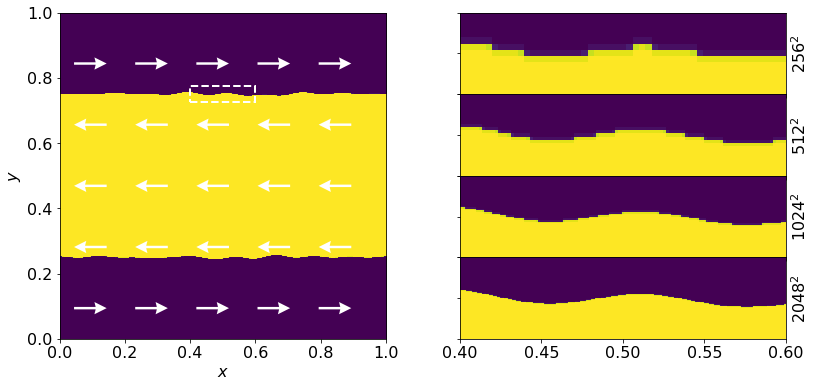

In [6]:
fig = plt.figure(constrained_layout=False, figsize=(14, 6))
widths = [1, 1]
heights = [1, 1, 1, 1]
extent, cm = get_extents_cm(files[0])
gs = fig.add_gridspec(4, 2, width_ratios=widths, height_ratios=heights,
                      hspace=0.001, wspace=0.05)
ax_main = fig.add_subplot(gs[:, 0])
ax_main.imshow(numpy.transpose(densities[-1]),
               interpolation="nearest", origin="lower",
               extent=extent,
               cmap=cm)
step = 384
start = step//2
ax_main.quiver(xy[-1][0][start::step,start::step], xy[-1][1][start::step,start::step],
               velocities[-1][0][start::step,start::step], velocities[-1][1][start::step,start::step],
               color='w', pivot='mid', scale=5, headwidth=5)
ax_main.set_xlabel(r"$x$")
ax_main.set_ylabel(r"$y$")
zoom_axes = []
zoom_width = 0.2
extents = [extent[0] + (0.5-zoom_width/2)*(extent[1]-extent[0]),
           extent[0] + (0.5+zoom_width/2)*(extent[1]-extent[0]),
           extent[2] + (0.75-zoom_width/8)*(extent[3]-extent[2]),
           extent[2] + (0.75+zoom_width/8)*(extent[3]-extent[2])]

rect = Rectangle((extents[0], extents[2]), extents[1]-extents[0], extents[3]-extents[2],
                 linewidth=2, linestyle='--', edgecolor='w', facecolor='none')
ax_main.add_patch(rect)

for i in range(4):
    iextents=[int(sizes[i]*e) for e in extents]
    zoom_axes.append(fig.add_subplot(gs[i, 1]))
    zoom_axes[i].imshow(numpy.transpose(densities[i][iextents[0]:iextents[1], iextents[2]:iextents[3]]),
                        interpolation="nearest", origin="lower",
                        extent=extents,
                        cmap=cm)
    # zoom_axes[i].set_axis_off()
    if i != 3:
        zoom_axes[i].set_xticklabels([])
    zoom_axes[i].set_yticklabels([])
    zoom_axes[i].set_ylabel(fr"{sizes[i]}${{}}^2$")
    zoom_axes[i].yaxis.set_label_position("right")

# plt.savefig("kh_plot_id.pdf", bbox_inches="tight")
# plt.savefig("kh_plot_id.png")
# plt.show()

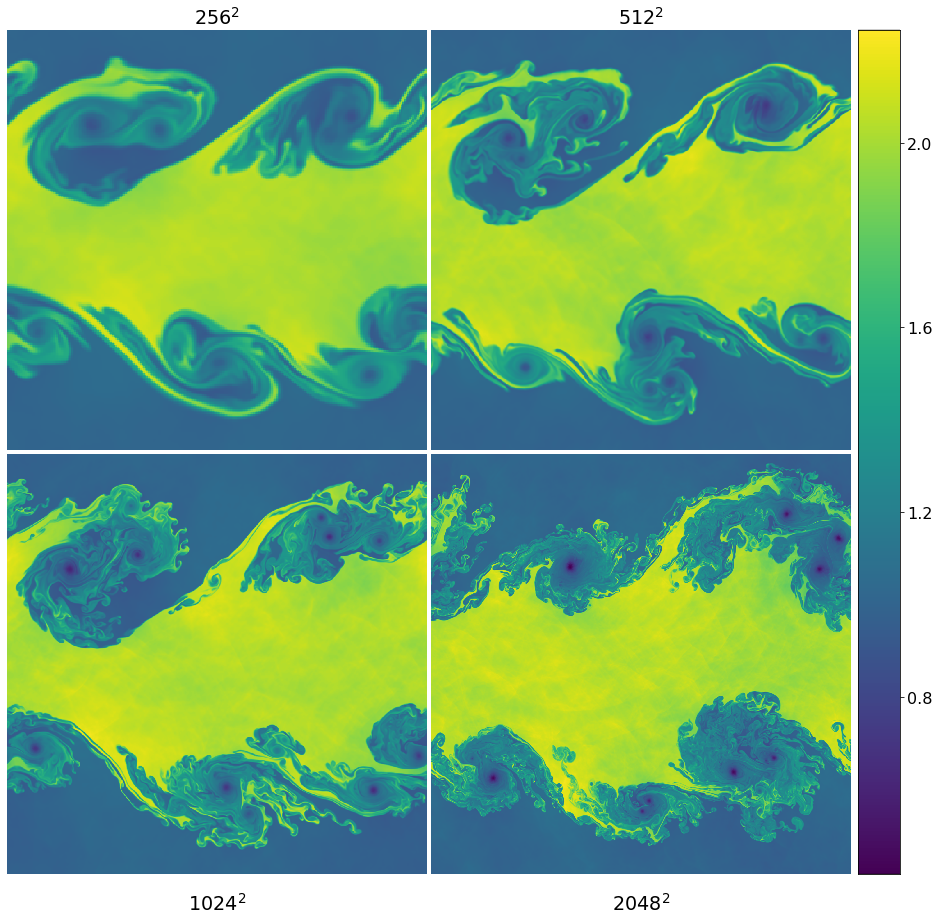

In [10]:
files = ['kh_random_outputs/256/kh_random_256_1234_3207.h5',
         'kh_random_outputs/512/kh_random_512_1234_6535.h5',
         'kh_random_outputs/1024/kh_random_1024_1234_13216.h5',
         'kh_random_outputs/2048/kh_random_2048_1234_27161.h5']
sizes = [256, 512, 1024, 2048]

fig = plt.figure(figsize=(16, 16))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

densities = []
max_rho = -numpy.inf
min_rho = numpy.inf
extent, cm = get_extents_cm(files[0])
for f in files:
    density = get_density(f)
    x, y = get_xy(f)
    densities.append(density)
    xy.append((x, y))
    max_rho = max(max_rho, numpy.max(density))
    min_rho = min(min_rho, numpy.min(density))

for ax, rho, size in zip(grid, densities, sizes):
    ax.set_axis_off()
    im = ax.imshow(numpy.transpose(rho),
                   interpolation="nearest", origin="lower",
                   extent=extent,
                   vmin=min_rho, vmax=max_rho,
                   cmap=cm)

    if size in sizes[:2]:
        ax.set_title(fr"{size}${{}}^2$")
    else:
        ax.set_title(fr"{size}${{}}^2$", y=-0.1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

cbar = ax.cax.colorbar(im)

# plt.savefig('kh_rho_all_1234.pdf', bbox_inches="tight")
# plt.savefig('kh_rho_all_1234.png')
plt.show()


In [5]:
resolutions = [128, 256, 512]
mean_rhos = []
var_rhos = []
mean_vorticities = []
var_vorticities = []
resolutions_densities = []
resolutions_vorticities = []
mean_rho_lims = [numpy.inf, -numpy.inf]
var_rho_lims = [numpy.inf, -numpy.inf]
mean_vorticity_lims = [numpy.inf, -numpy.inf]
var_vorticity_lims = [numpy.inf, -numpy.inf]
xys = []
for resolution in resolutions:
    basename = f'kh_random_outputs/{resolution}/kh_random_{resolution}'

    files = glob.glob(basename+'_[0-9]*_[1-9][0-9]*.h5')

    xys.append(get_xy(files[0]))
    files_size = (len(files), *(xys[-1][0].shape))
    all_densities = numpy.zeros(files_size)
    all_vorticities = numpy.zeros_like(all_densities)
    for i, f in tqdm(enumerate(files), total=len(files)):
        density, vorticity = get_density_vorticity(f)
        all_densities[i, :, :] = density
        all_vorticities[i, :, :] = vorticity
        
    resolutions_densities.append(all_densities)
    resolutions_vorticities.append(all_vorticities)

    mean_rho = all_densities.mean(axis=0)
    var_rho = all_densities.var(axis=0)
    mean_vorticity = all_vorticities.mean(axis=0)
    var_vorticity = all_vorticities.var(axis=0)
    mean_rhos.append(mean_rho)
    var_rhos.append(var_rho)
    mean_vorticities.append(mean_vorticity)
    var_vorticities.append(var_vorticity)
    mean_rho_lims[0] = min(mean_rho_lims[0], numpy.min(mean_rho))
    mean_rho_lims[1] = max(mean_rho_lims[1], numpy.max(mean_rho))
    var_rho_lims[0] = min(var_rho_lims[0], numpy.min(var_rho))
    var_rho_lims[1] = max(var_rho_lims[1], numpy.max(var_rho))
    mean_vorticity_lims[0] = min(mean_vorticity_lims[0], numpy.min(mean_vorticity))
    mean_vorticity_lims[1] = max(mean_vorticity_lims[1], numpy.max(mean_vorticity))
    var_vorticity_lims[0] = min(var_vorticity_lims[0], numpy.min(var_vorticity))
    var_vorticity_lims[1] = max(var_vorticity_lims[1], numpy.max(var_vorticity))

  0%|          | 0/1025 [00:00<?, ?it/s]/Users/ih3/Documents/github/pyro2/compressible/simulation.py:61: RuntimeWarning: invalid value encountered in true_divide
  q[:, :, ivars.iu] = U[:, :, ivars.ixmom]/U[:, :, ivars.idens]
/Users/ih3/Documents/github/pyro2/compressible/simulation.py:62: RuntimeWarning: invalid value encountered in true_divide
  q[:, :, ivars.iv] = U[:, :, ivars.iymom]/U[:, :, ivars.idens]
100%|██████████| 232/232 [00:21<00:00, 10.81it/s]


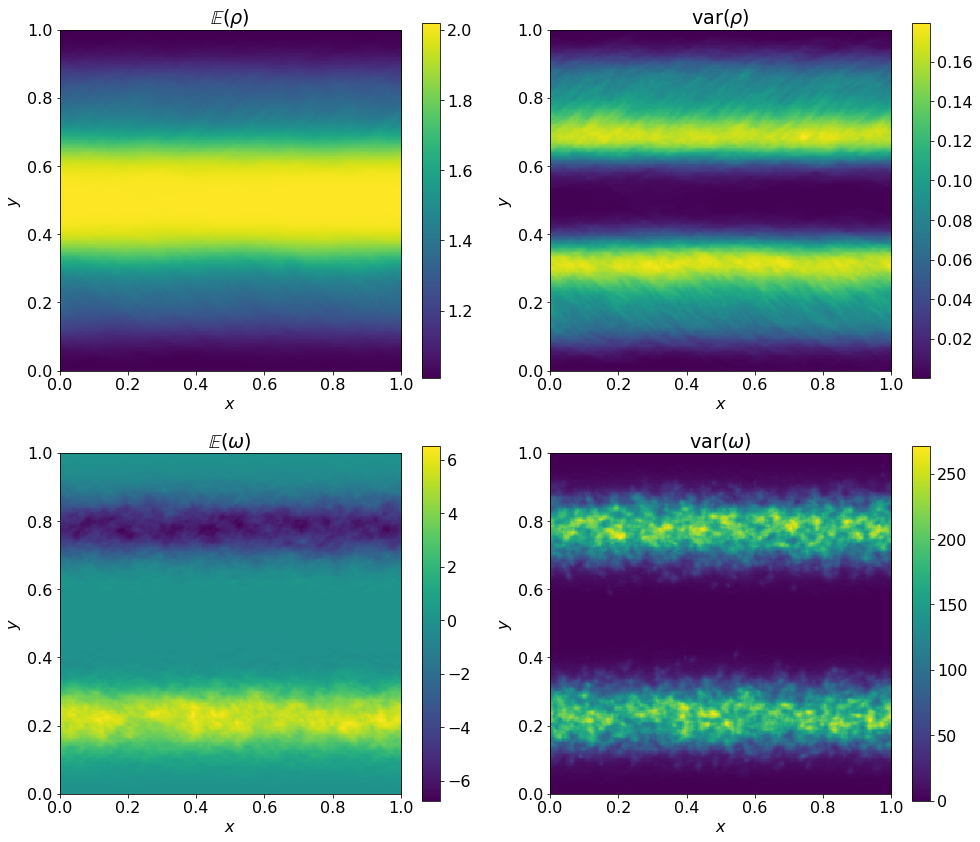

In [8]:
fields = [mean_rhos[1], var_rhos[1], mean_vorticities[1], var_vorticities[1]]
field_names = [r"$\mathbb{E}(\rho)$", r"var($\rho$)",
               r"$\mathbb{E}(\omega)$", r"var($\omega$)"]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for v, name, ax in zip(fields, field_names, axes.flat):
    im = ax.imshow(numpy.transpose(v),
                   interpolation="nearest", origin="lower",
                   extent=extent,
                   cmap=cm)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(name)
    cbar = fig.colorbar(im, ax=ax)
fig.tight_layout()

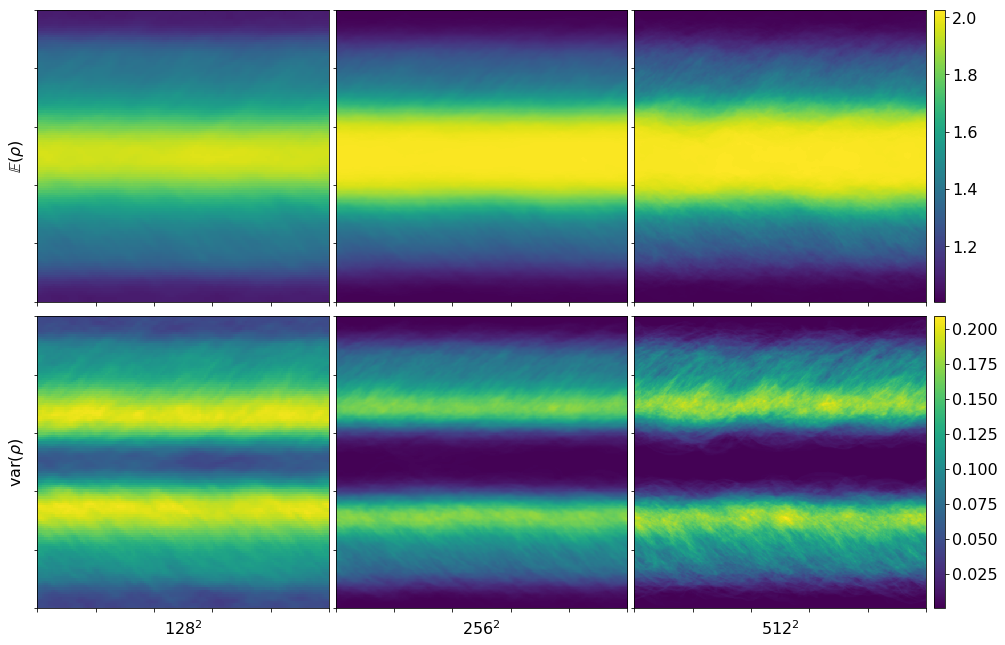

In [9]:
# fields = [mean_rhos, var_rhos, mean_vorticities, var_vorticities]
# field_names = [r"$\mathbb{E}(\rho)$", r"var($\rho$)",
#                r"$\mathbb{E}(\omega)$", r"var($\omega$)"]
# fig, axes = plt.subplots(4, 3, figsize=(14, 14))
fields = [mean_rhos, var_rhos]
field_names = [r"$\mathbb{E}(\rho)$", r"var($\rho$)"]
fig, axes = plt.subplots(2, 3, figsize=(16, 11), sharex=True, sharey=True,
                         gridspec_kw={'hspace': 0.05, 'wspace': 0.01, 'right': 0.9})

for row, (field, name) in enumerate(zip(fields, field_names)):
    for col, resolution in enumerate(resolutions):
        ax = axes[row, col]
        if row < 2:
            local_cm = cm
            if row == 0:
                vmin = mean_rho_lims[0]
                vmax = mean_rho_lims[1]
            else:
                vmin = var_rho_lims[0]
                vmax = var_rho_lims[1]
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        else:
            local_cm = mpl.cm.RdBu_r
            if row == 2:
                vmax = numpy.max(numpy.abs(mean_vorticity_lims))
                vmin = -vmax
            else:
                vmax = numpy.max(numpy.abs(var_vorticity_lims))
                vmin = -vmax
#             norm = mpl.colors.SymLogNorm(linthresh=1, linscale=1,
#                                          vmin=vmin, vmax=vmax)
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        im = ax.imshow(numpy.transpose(field[col]),
                       interpolation="nearest", origin="lower",
                       extent=extent,
                       norm=norm,
                       cmap=local_cm)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
#         if row == 3:
        if row == 1:
            ax.set_xlabel(rf"{resolution}${{}}^2$")
        if col == 0:
            ax.set_ylabel(name)
        if col == 2:
            pos = ax.get_position()
            cbar_ax = fig.add_axes([0.905, pos.y0, 0.01, pos.height])
            cbar = fig.colorbar(im, cax=cbar_ax)

# plt.savefig("kh_mean_var_all.png")
plt.show()

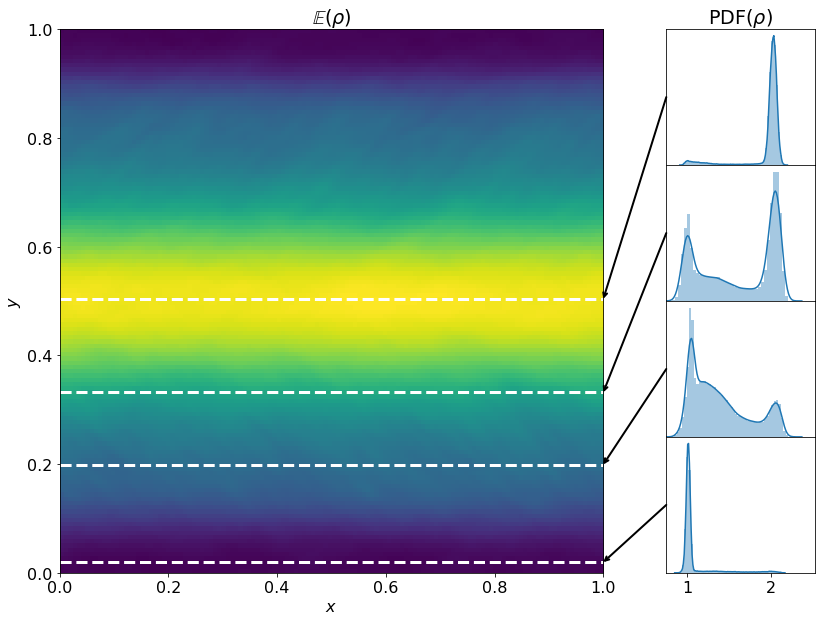

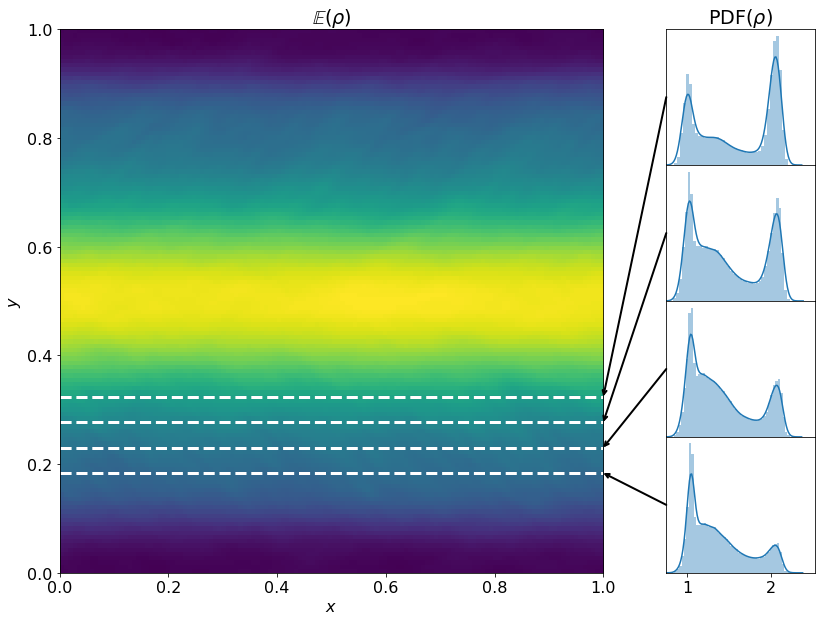

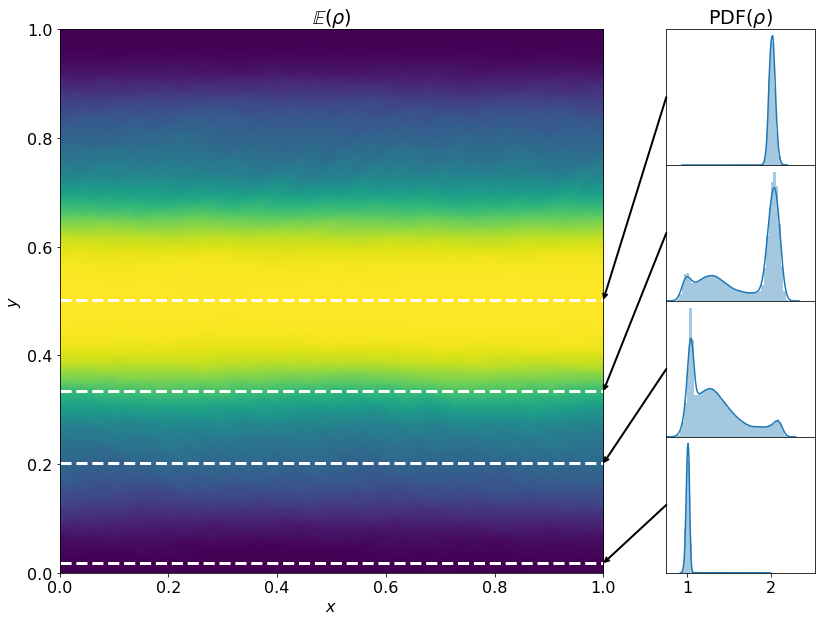

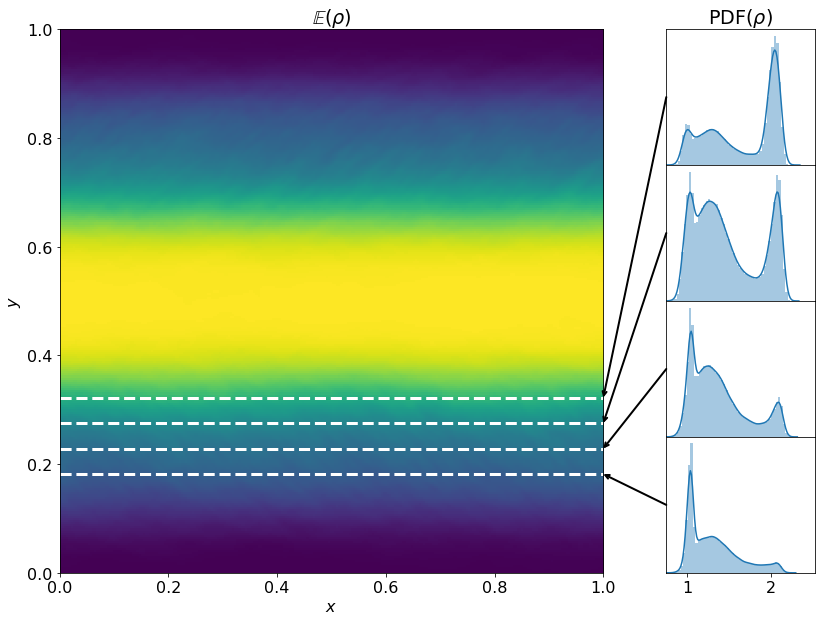

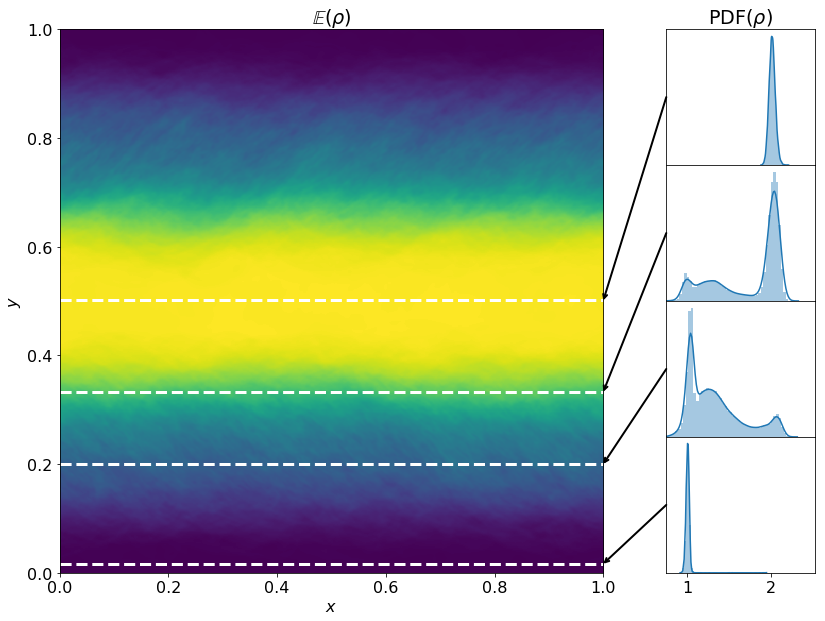

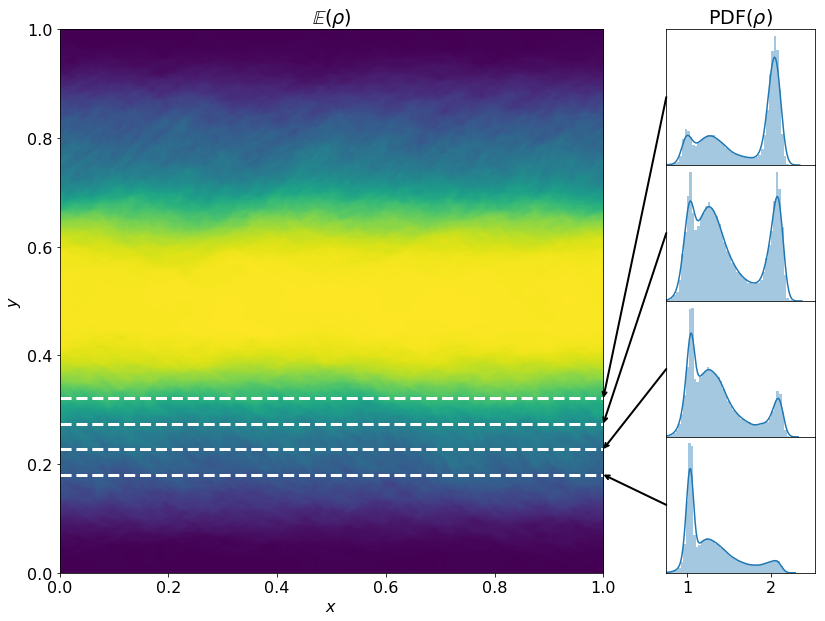

In [48]:
# res_index = 2
for res_index in range(len(resolutions)):
    res = resolutions[res_index]
    all_densities = resolutions_densities[res_index]
    size_j = all_densities.shape[-2]
    widths = [1, 0.25]
    heights = [1, 1, 1, 1]
    y_vals = xys[res_index][1][0,:]
    # j_indexes_all = [[size_j//2, size_j//3, size_j//5, size_j//60],
    #                  [164, 140, 116, 92]]
    # j_indexes_all = [[size_j//2, size_j//3, size_j//5, size_j//60],
    #                  [82, 70, 58, 46]]
    j_indexes_all = [[size_j//2, size_j//3, size_j//5, size_j//60],
                     2**res_index*numpy.array([41, 35, 29, 23], dtype=int)]
    for fig_j, j_indexes in enumerate(j_indexes_all):
        fig = plt.figure(constrained_layout=False, figsize=(14, 10))
        gs = fig.add_gridspec(4, 2, width_ratios=widths, height_ratios=heights,
                              hspace=0.001, wspace=0.1)
        fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)
        ax_main = fig.add_subplot(gs[:, 0])
        ax_main.imshow(numpy.transpose(mean_rhos[res_index]),
                       interpolation="nearest", origin="lower",
                       extent=extent,
                       cmap=cm)
        ax_main.set_xlabel(r"$x$")
        ax_main.set_ylabel(r"$y$")
        ax_main.set_title(r"$\mathbb{E}(\rho)$")
        for i, j_i in enumerate(j_indexes):
            ax_main.axhline(y_vals[j_i], extent[0], extent[1], ls='--', lw=3, color='white')
            ax = fig.add_subplot(gs[i, 1])
            seaborn.distplot(numpy.ravel(all_densities[:, :, j_i]), ax=ax, norm_hist=True)
        #     ax.set_xlabel(r"$\rho$")
            ax.set_xlim(mean_rho_lims[0]*0.75, mean_rho_lims[1]*1.25)
            ax.set_yticks([])
            conn = ConnectionPatch(xyA=(ax.get_xlim()[0], numpy.mean(ax.get_ylim())),
                                   xyB=(extent[1], y_vals[j_i]),
                                   coordsA='data', coordsB='data',
                                   axesA=ax, axesB=ax_main,
                                   arrowstyle='->', lw=2)
            ax.add_artist(conn)
            if i == 0:
                ax.set_title(r"PDF($\rho$)")
            if i != 3:
                ax.set_xticks([])

#         plt.savefig(f"var_mean_kde_{res}_plot{fig_j}.pdf", bbox_inches="tight")
#         plt.savefig(f"var_mean_kde_{res}_plot{fig_j}.png")
#         plt.show()

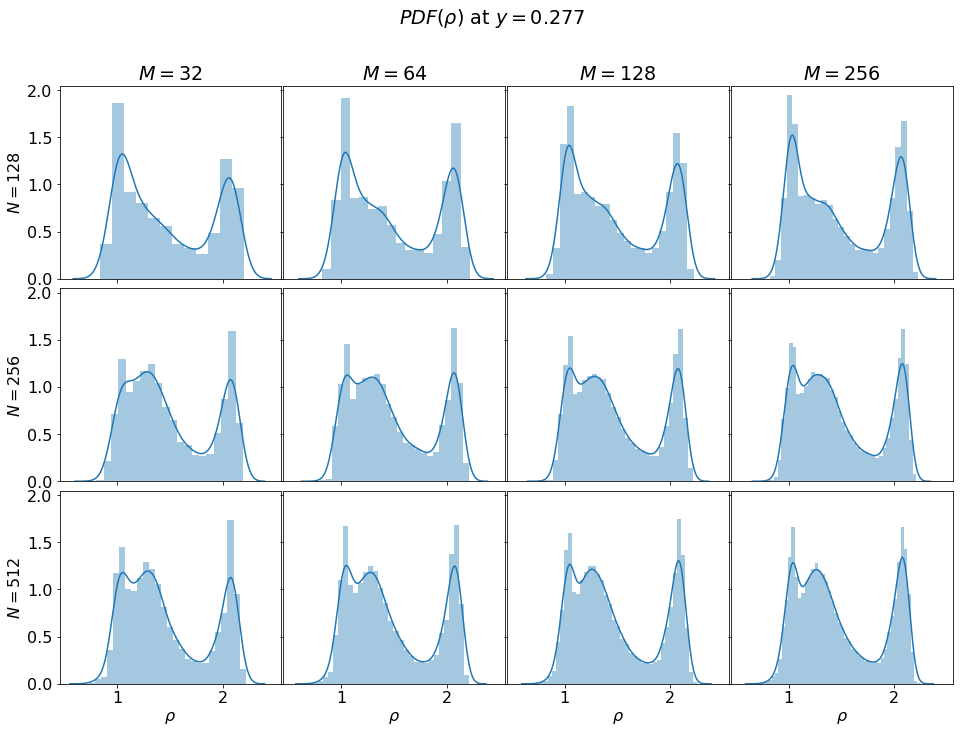

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(16, 11), sharex=True, sharey=True,
                         gridspec_kw={'hspace': 0.05, 'wspace': 0.01})
j_index = 35
y_val = xys[0][1][0, j_index]
for col, reals in enumerate([32, 64, 128, 256]):
    for row, res in enumerate(resolutions):
        j_i = 2**row * j_index
        all_densities = resolutions_densities[row]
        seaborn.distplot(numpy.ravel(all_densities[:reals, :, j_i]), ax=axes[row, col], norm_hist=True)
        if axes[row, col].is_first_row():
            axes[row, col].set_title(rf'$M={reals}$')
        if axes[row, col].is_first_col():
            axes[row, col].set_ylabel(rf'$N={res}$')
        if axes[row, col].is_last_row():
            axes[row, col].set_xlabel(r'$\rho$')
fig.suptitle(rf'$PDF(\rho)$ at $y={y_val:.3f}$')
# plt.savefig("rho_pdfs_all.png")
plt.show()

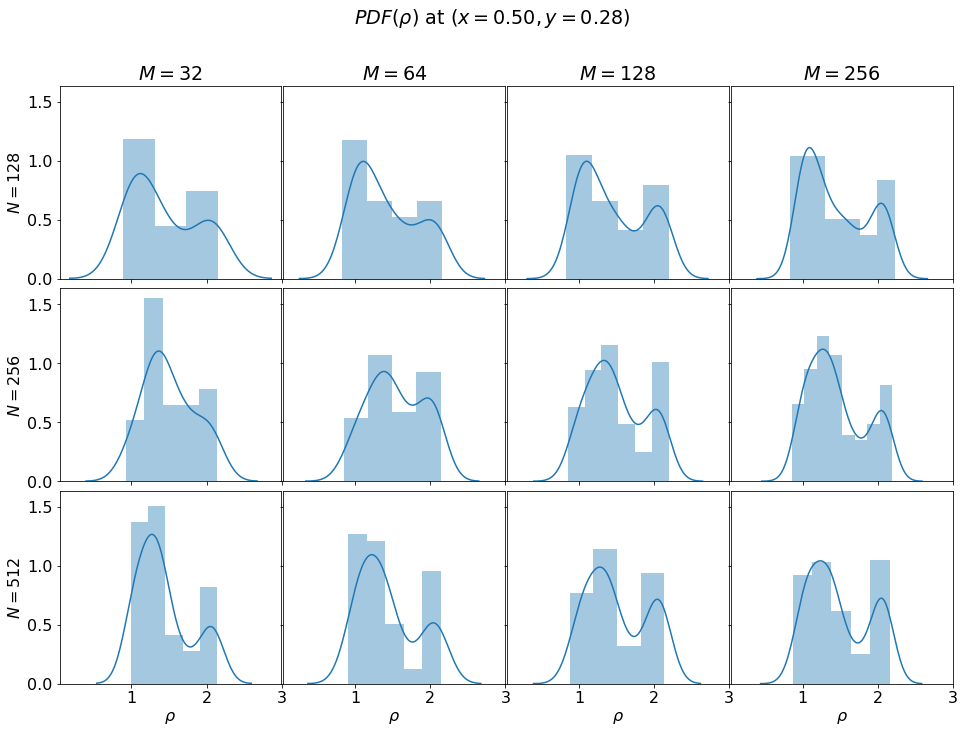

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(16, 11), sharex=True, sharey=True,
                         gridspec_kw={'hspace': 0.05, 'wspace': 0.01})
i_index = 63
j_index = 35
x_val = xys[0][0][i_index, 0]
y_val = xys[0][1][0, j_index]
for col, reals in enumerate([32, 64, 128, 256]):
    for row, res in enumerate(resolutions):
        i_i = 2**row * i_index
        j_i = 2**row * j_index
        all_densities = resolutions_densities[row]
        seaborn.distplot(numpy.ravel(all_densities[:reals, i_i, j_i]), ax=axes[row, col], norm_hist=True)
        if axes[row, col].is_first_row():
            axes[row, col].set_title(rf'$M={reals}$')
        if axes[row, col].is_first_col():
            axes[row, col].set_ylabel(rf'$N={res}$')
        if axes[row, col].is_last_row():
            axes[row, col].set_xlabel(r'$\rho$')
fig.suptitle(rf'$PDF(\rho)$ at $(x={x_val:.2f}, y={y_val:.2f})$')
# plt.savefig("rho_pdfs_all_point.png")
plt.show()

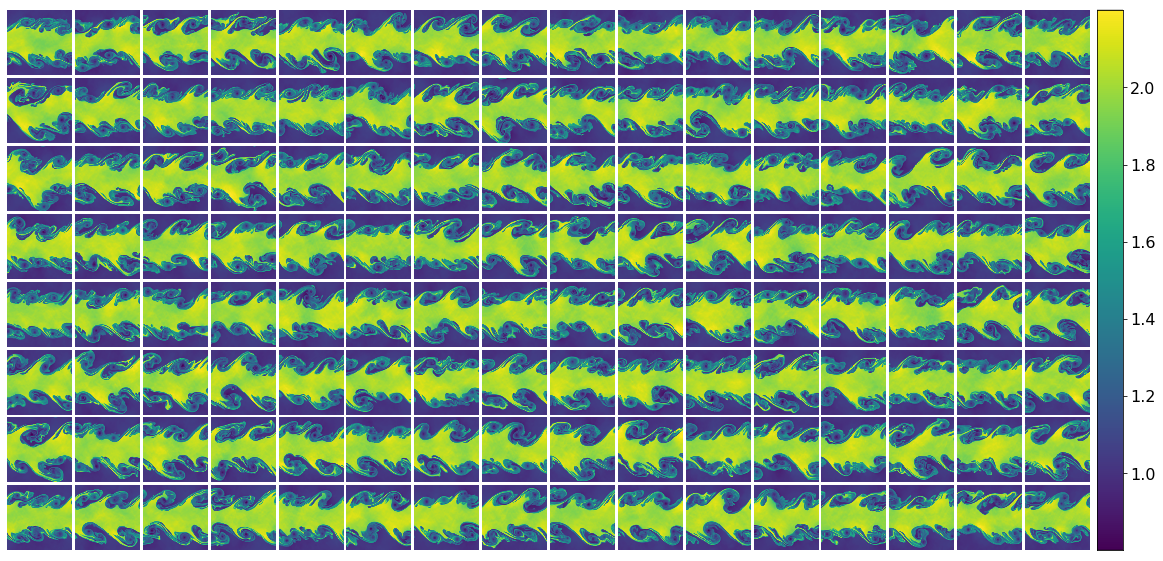

In [47]:
fig = plt.figure(figsize=(20, 10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2**3, 2**4),
                axes_pad=0.04,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

for ax, rho in zip(grid, resolutions_densities[1][:128]):
    ax.set_axis_off()
    im = ax.imshow(numpy.transpose(rho),
                   interpolation="nearest", origin="lower",
                   extent=extent,
                   vmin=0.8, vmax=2.2,
                   cmap=cm)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

cbar = ax.cax.colorbar(im, ticks=numpy.linspace(1, 2, 6))
# plt.savefig("kh_plot_128_realizations.png")
# plt.show()

# Other, older, plots

In [13]:
realizations = list(range(1,129))

densities = []
max_rho = -numpy.inf
min_rho = numpy.inf
for r in realizations:
    f = glob.glob(f'kh_random_outputs/256/kh_random_256_{r}_[1-9]*.h5')
    assert len(f)==1
    s = io.read(f[0])
    ivars = compressible.Variables(s.cc_data)
    myg = s.cc_data.grid
    gamma = s.cc_data.get_aux("gamma")
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    densities.append(q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.irho])
    max_rho = max(max_rho, numpy.max(q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.irho]))
    min_rho = min(min_rho, numpy.min(q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.irho]))

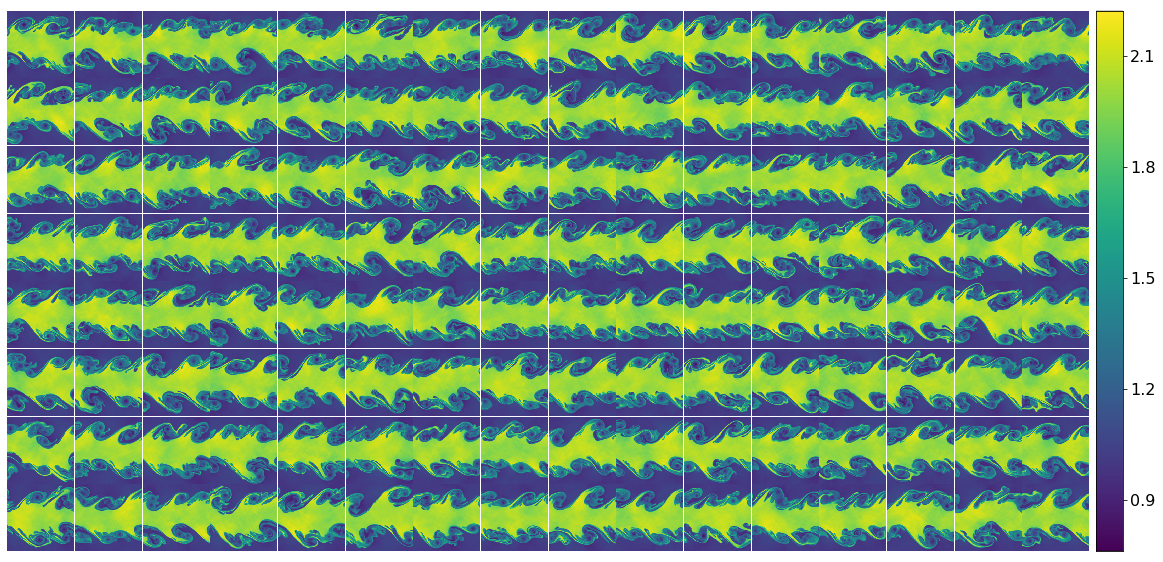

In [14]:
fig = plt.figure(figsize=(20, 10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2**3, 2**4),
                axes_pad=0.01,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

for ax, rho in zip(grid, densities):
    ax.set_axis_off()
    im = ax.imshow(numpy.transpose(rho),
                   interpolation="nearest", origin="lower",
                   extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
                   vmin = min_rho, vmax=max_rho,
                   cmap=s.cm)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

cbar = ax.cax.colorbar(im)
# plt.savefig("kh_plot_128_realizations.png")
# plt.show()

In [15]:
# realizations = list(range(1,513))

# densities = []
# max_rho = -numpy.inf
# min_rho = numpy.inf
# for r in realizations:
#     f = glob.glob(f'kh_random_outputs/256/kh_random_256_{r}_[1-9]*.h5')
#     assert len(f)==1
#     s = io.read(f[0])
#     ivars = compressible.Variables(s.cc_data)
#     myg = s.cc_data.grid
#     gamma = s.cc_data.get_aux("gamma")
#     q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
#                                   s.cc_data.grid)
#     densities.append(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho])
#     max_rho = max(max_rho, numpy.max(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]))
#     min_rho = min(min_rho, numpy.min(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]))

In [16]:
# fig = plt.figure(figsize=(20, 10))

# grid = AxesGrid(fig, 111,
#                 nrows_ncols=(2**4, 2**5),
#                 axes_pad=0.01,
#                 cbar_mode='single',
#                 cbar_location='right',
#                 cbar_pad=0.1
#                 )

# for ax, rho in zip(grid, densities):
#     ax.set_axis_off()
#     im = ax.imshow(numpy.transpose(rho),
#                    interpolation="nearest", origin="lower",
#                    extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
#                    vmin = min_rho, vmax=max_rho,
#                    cmap=s.cm)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# cbar = ax.cax.colorbar(im)

In [15]:
all_kdensities_density = []
all_supports_density = []
all_kdensities_vorticity = []
all_supports_vorticity = []
for all_densities, all_vorticities in zip(resolutions_densities, resolutions_vorticities):
    max_density = numpy.max(all_densities)
    min_density = numpy.min(all_densities)
    d_density = max_density - min_density
    support = numpy.linspace(min_density - d_density, max_density + d_density,
                            500)
    j_y = all_densities.shape[-1]//4
    densities = numpy.mean(all_densities[:, :, j_y], axis=1)
    bandwidth = 1.06 * densities.std() * densities.size ** (-1 / 5.)
    kernels = []
    for x_i in densities:
       kernel = stats.norm(x_i, bandwidth).pdf(support)
       kernels.append(kernel)
    kdensity = numpy.sum(kernels, axis=0)
    kdensity /= trapz(kdensity, support)
    all_kdensities_density.append(kdensity)
    all_supports_density.append(support)
    
    max_vorticity = numpy.max(all_vorticities)
    min_vorticity = numpy.min(all_vorticities)
    d_vorticity = max_vorticity - min_vorticity
    support = numpy.linspace(min_vorticity - d_vorticity, max_vorticity + d_vorticity,
                            500)
    j_y = all_vorticities.shape[-1]//4
    i_x = all_vorticities.shape[-2]//2
    densities = all_vorticities[:, i_x, j_y]
    bandwidth = 1.06 * densities.std() * densities.size ** (-1 / 5.)
    kernels = []
    for x_i in densities:
       kernel = stats.norm(x_i, bandwidth).pdf(support)
       kernels.append(kernel)
    kdensity = numpy.sum(kernels, axis=0)
    kdensity /= trapz(kdensity, support)
    all_kdensities_vorticity.append(kdensity)
    all_supports_vorticity.append(support)

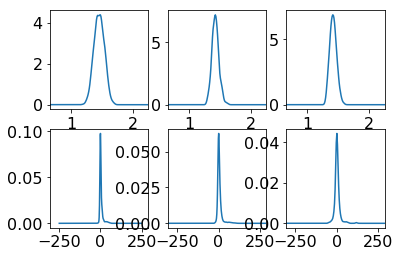

In [16]:
fig, ax = plt.subplots(2, 3)
for i, (s_d, d, s_v, v) in enumerate(zip(all_supports_density, all_kdensities_density,
                                         all_supports_vorticity, all_kdensities_vorticity)):
    ax[0, i].plot(s_d, d)
    ax[0, i].set_xlim(min_density, max_density)
    ax[1, i].plot(s_v, v)
    ax[1, i].set_xlim(min_vorticity, max_vorticity)
ax[0, 0].set_ylabel(r"$\rho$")
ax[1, 0].set_ylabel(r"$\omega$")
plt.show()

In [17]:
v = resolutions_vorticities[1]
numpy.unravel_index(numpy.argmax(v), v.shape)

(42, 54, 52)

In [18]:
import seaborn

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


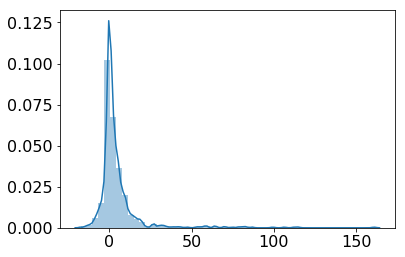

In [19]:
seaborn.distplot(v[:, 54, 52])

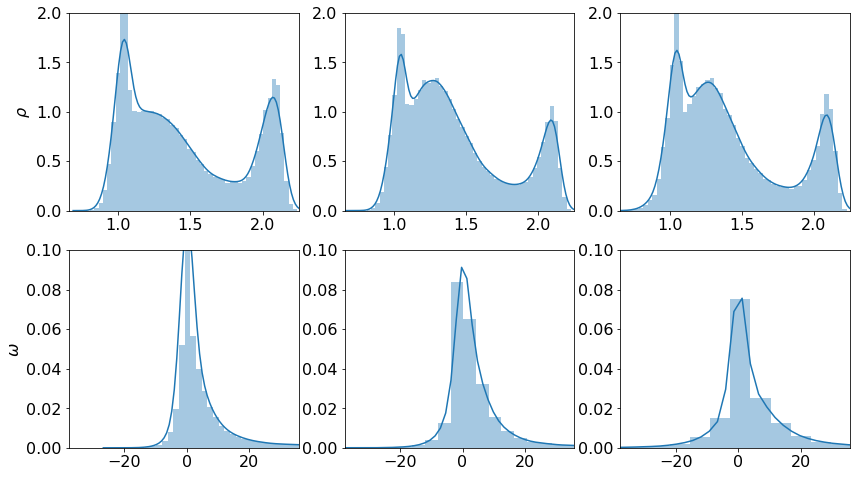

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(14,8))
for i, (d, v) in enumerate(zip(resolutions_densities, resolutions_vorticities)):
    j_y = d.shape[-1]//4
    i_x = d.shape[-2]//2
    j_steps = [1, 3, 5][i]
    j_steps = 1
#     print(i, j_steps)
    seaborn.distplot(numpy.ravel(d[:, :, j_y:j_y+j_steps]), ax=ax[0, i])
    ax[0, i].set_xlim(min_density, max_density)
    ax[0, i].set_ylim(0, 2)
    seaborn.distplot(numpy.ravel(v[:, :, j_y:j_y+j_steps]), ax=ax[1, i], kde_kws={'bw': 2})
    ax[1, i].set_xlim(min_vorticity/8, max_vorticity/8)
    ax[1, i].set_ylim(0, 0.1)
ax[0, 0].set_ylabel(r"$\rho$")
ax[1, 0].set_ylabel(r"$\omega$")
plt.show()

In [15]:
basename = 'kh_random_outputs/256/kh_random_256'
# basename = 'kh_random_outputs/128/kh_random_128'

In [16]:
files = glob.glob(basename+'_[0-9]*_[1-9][0-9]*.h5')

sim_first = io.read(files[0])
ivars = compressible.Variables(sim_first.cc_data)
myg = sim_first.cc_data.grid
files_size = (len(files), myg.ihi-myg.ilo+1, myg.jhi-myg.jlo+1)
all_densities = numpy.zeros(files_size)
for i, f in tqdm(enumerate(files), total=len(files)):
    s = io.read(f)
    gamma = s.cc_data.get_aux("gamma")
    dx = s.cc_data.grid.dx
    dy = s.cc_data.grid.dy
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    all_densities[i, :, :] = q[myg.ilo:myg.ihi+1, myg.jlo:myg.jhi+1, ivars.irho]

mean_rho = all_densities.mean(axis=0)
var_rho = all_densities.var(axis=0)

100%|██████████| 908/908 [00:10<00:00, 87.34it/s]


In [17]:
max_density = numpy.max(all_densities)
min_density = numpy.min(all_densities)
d_density = max_density - min_density
support = numpy.linspace(min_density - d_density, max_density + d_density,
                        500)
kdensity = numpy.zeros((len(support), files_size[2]))
for j_y in tqdm(range(files_size[2])):
    densities = numpy.mean(all_densities[:, :, j_y], axis=1)
    bandwidth = 1.06 * densities.std() * densities.size ** (-1 / 5.)
    kernels = []
    for x_i in densities:
       kernel = stats.norm(x_i, bandwidth).pdf(support)
       kernels.append(kernel)
    kdensity[:, j_y] = numpy.sum(kernels, axis=0)
    kdensity[:, j_y] /= trapz(kdensity[:, j_y], support)

100%|██████████| 256/256 [02:41<00:00,  1.67it/s]


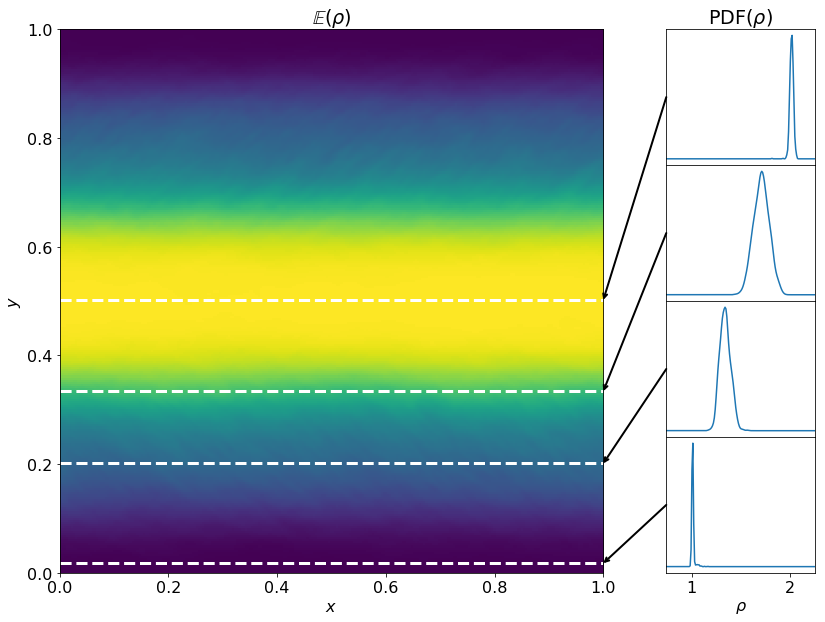

In [18]:
fig = plt.figure(constrained_layout=False, figsize=(14, 10))
widths = [1, 0.25]
heights = [1, 1, 1, 1]
gs = fig.add_gridspec(4, 2, width_ratios=widths, height_ratios=heights,
                      hspace=0.001, wspace=0.1)
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)
ax_main = fig.add_subplot(gs[:, 0])
ax_main.imshow(numpy.transpose(mean_rho),
               interpolation="nearest", origin="lower",
               extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
               cmap=s.cm)
ax_main.set_xlabel(r"$x$")
ax_main.set_ylabel(r"$y$")
ax_main.set_title(r"$\mathbb{E}(\rho)$")
size_j = mean_rho.shape[1]
j_indexes = [size_j//2, size_j//3, size_j//5, size_j//60]
y_vals = myg.y[myg.jlo:myg.jhi]
for i, j_i in enumerate(j_indexes):
    ax_main.axhline(y_vals[j_i], myg.xmin, myg.xmax, ls='--', lw=3, color='white')
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(support, kdensity[:, j_i])
    ax.set_xlim(min_density, max_density)
    ax.set_xlabel(r"$\rho$")
    ax.set_yticks([])
    ave_kdensity = (min(kdensity[:, j_i])+max(kdensity[:, j_i]))/2
    conn = ConnectionPatch(xyA=(min_density, ave_kdensity),
                           xyB=(myg.xmax, y_vals[j_i]),
                           coordsA='data', coordsB='data',
                           axesA=ax, axesB=ax_main,
                           arrowstyle='->', lw=2)
    ax.add_artist(conn)
    if i==0:
        ax.set_title(r"PDF($\rho$)")

# plt.savefig("var_mean_kde_256.pdf", bbox_inches="tight")
# plt.savefig("var_mean_kde_256.png")
# plt.show()